# Pipeline for High-z Radio Galaxies 12: Create lists (files) with radio AGN candidates

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import mpl_scatter_density
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Methods for the use of values in Confusion Matrices.

---

## Reading data

Flags.

In [3]:
save_plot_flag      = False
save_preds_flag     = False
load_models_flag    = True
predict_only_hi_z   = False
use_zeroth_model    = False
use_second_z_model  = False  # z >= 3.6 (with SMOGN), or, if needed, z >= 4.0

In [4]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'

In [5]:
if used_area != 'S82':
    compare_A17_flag = False

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [11]:
full_catalog_df['radio_AGN']      = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

Discard minor features.

In [12]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

#### As we want to predict, only use sources that have not previous spectroscopic classification

In [13]:
print(f'The used data set (in {used_area}) has {len(full_catalog_df):,} sources.')
print(f'And {np.sum(filter_non_confirmed):,} have previous spectroscopic classification.')

The used data set (in HETDEX) has 6,729,647 sources.
And 83,409 have previous spectroscopic classification.


In [14]:
full_catalog_df                     = full_catalog_df.loc[~filter_non_confirmed]

In [15]:
print(f'This pipeline will predict properties for {len(full_catalog_df):,} sources in {used_area}.')

This pipeline will predict properties for 6,646,238 sources in HETDEX.


---

### Load models

In [16]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [17]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df['Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=7)
pred_probs_AGN  = cal_AGN_gal_clf.predict_proba(full_catalog_df.loc[:, gf.get_final_column_names(AGN_gal_clf, full_catalog_df)])[:, 1]
full_catalog_df['Prob_AGN'] = pred_probs_AGN

In [18]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df['Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=7)
pred_probs_rad  = cal_radio_det_clf.predict_proba(full_catalog_df.loc[:, gf.get_final_column_names(radio_det_clf, full_catalog_df)])[:, 1]
full_catalog_df['Prob_radio'] = pred_probs_rad

In [19]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df['pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [20]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

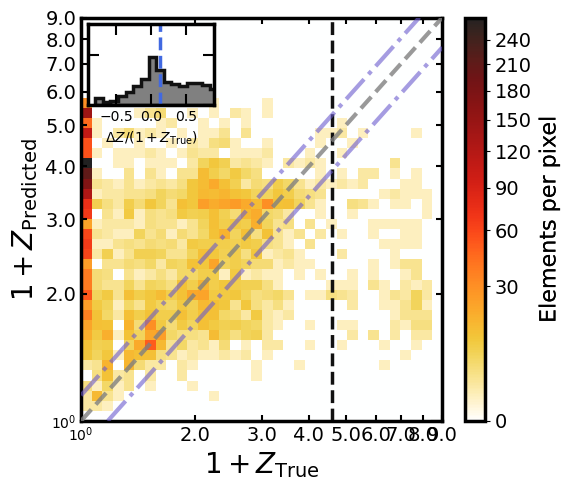

In [21]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + gv.high_z_limit), ls='--', c='k', lw=2.5)
if use_second_z_model:
    ax1.set_ylabel('$1 + Z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

In [22]:
full_catalog_df['pred_prob_class']    = (full_catalog_df.loc[:, 'Prob_AGN']   >= gv.cal_AGN_thresh).astype(int)
full_catalog_df['pred_prob_radio']    = (full_catalog_df.loc[:, 'Prob_radio'] >= gv.cal_radio_thresh).astype(int)

In [23]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'Score_radio']
full_catalog_df['pred_prob_rAGN']     = np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1)
full_catalog_df['Prob_rAGN']          = full_catalog_df.loc[:, 'Prob_AGN'] * full_catalog_df.loc[:, 'Prob_radio']

rad_score_scaler                      = MinMaxScaler()
full_catalog_df['scaled_score_radio'] = rad_score_scaler.fit_transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [24]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,6646238.0,6.646238e+06,6.646238e+06,6.646238e+06,9662.000000,6.646238e+06
mean,0.5,1.205351e-01,4.826069e-02,3.345667e-02,0.400833,2.201876e+00
std,0.0,3.255863e-01,2.143166e-01,1.798258e-01,0.925536,7.072563e-01
min,0.5,0.000000e+00,0.000000e+00,0.000000e+00,-0.004140,2.300000e-02
25%,0.5,0.000000e+00,0.000000e+00,0.000000e+00,-0.000220,2.203000e+00
50%,0.5,0.000000e+00,0.000000e+00,0.000000e+00,-0.000010,2.252000e+00
75%,0.5,0.000000e+00,0.000000e+00,0.000000e+00,0.377580,2.318000e+00
max,0.5,1.000000e+00,1.000000e+00,1.000000e+00,7.028330,4.732000e+00


Obtain intermediate metrics

In [25]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [26]:
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN']          >= threshold_AGN) &\
#                             np.array(full_catalog_df.loc[:, 'Score_radio']      >= threshold_radio)
filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class']      == 1) &\
                            np.array(full_catalog_df.loc[:, 'pred_radio']    == 1)
filt_hiz_rAGN_p         = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class']      == 1)
filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio']      == 1)
num_AGN_p               = np.sum(filter_AGN_p)
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0))
num_radio_p             = np.sum(filter_radio_p)
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

### Select sources predicted to be Radio AGN

In [27]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_p]

In [28]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,55333.0,55333.0,55333.000000,55333.0,504.000000,55333.000000
mean,0.5,1.0,0.265465,1.0,0.680451,1.666190
std,0.0,0.0,0.441585,0.0,1.039101,0.920135
min,0.5,1.0,0.000000,1.0,-0.000570,0.026000
25%,0.5,1.0,0.000000,1.0,0.100000,0.943000
50%,0.5,1.0,0.000000,1.0,0.300000,1.602000
75%,0.5,1.0,1.000000,1.0,0.800000,2.701000
max,0.5,1.0,1.000000,1.0,6.879030,4.631000


Add individual metrics for redshift

In [29]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [30]:
str_0_t   = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t   = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t   = f'{num_AGN_t:,} are confirmed to be AGN. And, from the AGN,\n'
str_3_t   = f'{num_radio_AGN_t:,} are detected in radio.'

str_0_p   = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p   = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p   = f'{num_AGN_p:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p   = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

In [31]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)

------------------------------------------------------------
Out of 6,646,238 initial sources in HETDEX,
0 are confirmed to be galaxies. On the other side,
0 are confirmed to be AGN. And, from the AGN,
0 are detected in radio.
------------------------------------------------------------
Out of 0 initial radio-detected AGN in HETDEX,
5,845,133 are predicted to be galaxies. On the other side,
801,105 are predicted to be AGN. And, from the predicted AGN,
55,333 are predicted to be detected in radio.
------------------------------------------------------------


In [32]:
cols_4_table = show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN', 'Prob_AGN',\
                               'radio_detect', 'pred_radio', 'Score_radio', 'Prob_radio', 'Prob_rAGN', 'Z', 'pred_Z']

In [33]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = cols_4_table + cols_4_exp_all[used_area] + cols_photo

In [34]:
filter_new_rAGN = full_catalog_df.loc[:, 'radio_AGN'] == 0
if predict_only_hi_z:
    filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= gv.high_z_limit
elif not predict_only_hi_z:
    filter_high_z   = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)

In [35]:
full_catalog_df.loc[:, 'TYPE'] = full_catalog_df.loc[:, 'TYPE'].mask(full_catalog_df.loc[:, 'TYPE'] == '    ', 'CCCC')

In [36]:
display(full_catalog_df.loc[filter_high_z, cols_4_export].sort_values(by=['pred_Z'], ascending=False).head(15))

,Name,RA_ICRS,DE_ICRS,TYPE,band_num,class,pred_class,Score_AGN,Prob_AGN,radio_detect,pred_radio,Score_radio,Prob_radio,Prob_rAGN,Z,pred_Z,Total_flux_VLASS,Sint_LOFAR,Stotal_TGSS,FEP,TotalFlux_LoLSS,W1mproPM,W2mproPM,gmag,rmag,imag,zmag,ymag,Jmag,Hmag,Kmag,W3mag,W4mag
3410222,J132514.21+534447.1,201.309235,53.746429,CCCC,8,0.5,1,0.602275,0.213189,0,1,0.500049,0.198517,0.042322,NaN,4.631,15.21,17.520000,11.18,57.900002,12.91,18.823999,19.125999,23.299999,20.935801,19.635599,19.379000,19.478600,17.450001,17.24,16.590,16.670,14.62
955536,J125817.90+542010.4,194.574615,54.336243,CCCC,8,0.5,1,0.533006,0.275053,0,1,0.500053,0.195094,0.053661,-0.00013,4.587,15.21,17.520000,11.18,57.900002,12.91,18.729000,19.131001,23.299999,20.902399,19.560200,18.957800,18.644899,17.450001,17.24,16.590,16.670,14.62
6336407,J114811.78+543808.4,177.049072,54.635658,CCCC,8,0.5,1,0.738927,0.364926,0,1,0.500027,0.195094,0.071195,NaN,4.587,15.21,17.520000,11.18,57.900002,12.91,18.741999,19.075001,23.299999,21.018200,19.709400,19.038799,18.740801,17.450001,17.24,16.590,16.670,14.62
6010565,J133656.77+521243.0,204.236542,52.211956,CCCC,9,0.5,1,0.521439,0.114420,1,1,0.500008,0.208274,0.023831,NaN,4.497,15.21,15.703115,11.18,57.900002,12.91,18.851999,18.880001,19.289801,18.072001,16.869600,16.349199,16.088900,17.450001,17.24,16.590,16.563,14.62
2950162,J122528.35+502813.1,186.368164,50.470314,CCCC,9,0.5,1,0.824832,0.299150,0,1,0.500006,0.150290,0.044959,NaN,4.433,15.21,17.520000,11.18,57.900002,12.91,18.769999,19.043001,21.947100,20.680700,19.308300,18.710899,18.433901,17.450001,17.24,16.590,16.670,14.62
2646775,J113523.52+461640.9,173.848007,46.278038,CCCC,9,0.5,1,0.793412,0.218637,0,1,0.500050,0.150290,0.032859,NaN,4.418,15.21,17.520000,11.18,57.900002,12.91,18.639999,18.959000,21.891399,20.487101,19.184299,18.580900,18.304800,17.450001,17.24,16.590,16.670,14.62
3513647,J150436.99+525718.7,226.154129,52.955204,CCCC,9,0.5,1,0.810082,0.177472,0,1,0.500019,0.190640,0.033833,NaN,4.394,15.21,17.520000,11.18,57.900002,12.91,18.790998,19.116001,21.827600,20.683901,19.334200,18.735001,18.442301,17.450001,17.24,16.590,16.670,14.62
2275442,J131558.17+493553.9,198.992416,49.598297,CCCC,9,0.5,1,0.447276,0.305612,0,1,0.500008,0.255498,0.078083,NaN,4.320,15.21,17.520000,11.18,57.900002,12.91,18.793999,18.868000,22.151600,21.164600,19.866301,19.307501,19.049500,17.450001,17.24,16.590,16.670,14.62
5298136,J133034.86+471228.8,202.645233,47.208038,CCCC,12,0.5,1,0.612072,0.057340,0,1,0.500009,0.107005,0.006136,NaN,4.315,15.21,17.520000,11.18,57.900002,12.91,16.823999,17.365000,18.674101,17.008200,16.189100,15.909400,16.203501,16.054001,15.88,16.122,16.670,14.62
5677964,J133326.54+502358.5,203.360580,50.399582,CCCC,7,0.5,1,0.469213,0.318237,0,1,0.500015,0.284103,0.090412,NaN,4.145,15.21,17.520000,11.18,57.900002,12.91,19.608999,19.809999,23.299999,21.201599,20.999399,20.764700,21.400000,17.450001,17.24,16.590,16.670,14.62


In [37]:
if save_preds_flag:
    full_catalog_df.loc[filter_high_z, cols_4_export].sort_values(by=['pred_Z'],
     ascending=False).to_csv(gv.preds_path + f'predicted_rAGN_{used_area}.csv')

---